In [1]:
# Importing libraries

import os
import pandas as pd
from sklearn import model_selection
import numpy as np
import shutil
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import Image

In [8]:
# data directory
data_dir = 'processed_data/train/positive' 

In [12]:
!ls

31_train_yolov5.html   images		 test_bboxes.csv
31_train_yolov5.ipynb  labels		 test_bboxes_tf.csv
3_train_yolov5.html    processed_data	 test.mp4
3_train_yolov5.ipynb   requirements.txt  test.webm
3_train_yolov5.pdf     runs		 venv_yolo
augmented_BBox_df.csv  screen_cap.py	 yolov5
flask_app	       test


In [15]:
def get_file_path_df(folder):
  """
  Function to get name and path of .jpg files in the specified folder
  takes folder input and returns pandas dataframe
  """
  image_path = [] 
  image_name = [] 

  for root, dirs, files in os.walk(folder):
    for f in files:
      if f.endswith(".JPG"): # checking for JPG extension 
        image_name.append(f.split('.')[0])
        image_path.append(os.path.join(root, f)) # appending to image_path list
  # df = dataframe
  df_cols = {'image_name':image_name, 'path': image_path} # creating a dictionary
  df = pd.DataFrame(df_cols) # creating a dataframe
  return df

In [16]:
# getting absolute path of all images and storing in a dataframe called data_df
data_df = get_file_path_df(data_dir)

# displying random 5 rows
data_df.sample(5)

image_name                                             path
2536       G0011555       processed_data/train/positive/G0011555.JPG
670   G0028995_1391  processed_data/train/positive/G0028995_1391.JPG
1645       G0043312       processed_data/train/positive/G0043312.JPG
948   G0090163_1261  processed_data/train/positive/G0090163_1261.JPG
2490   G0022110_489   processed_data/train/positive/G0022110_489.JPG

In [17]:
data_df.shape

(2658, 2)

* Only positive images are considered for training YOLO
* Data contains 2658 images with potholes
* 80% of the data is used for training and 20% used for validation

In [9]:
# splitting the data in to train and validation 

train_df, valid_df = model_selection.train_test_split(data_df, test_size=0.2, random_state=21, shuffle=True)

In [11]:
# Number of images in training set
print(train_df.shape)

(2126, 2)


In [13]:
# Number of images in validation set
valid_df.shape

(532, 2)

In [14]:
# loading the csv file containing bounding box coordinates

bbox_df = pd.read_csv("augmented_BBox_df.csv")
bbox_df.head()

image_id       x       y   x_max   y_max
0  G0010033  1990.0  1406.0  2056.0  1420.0
1  G0010033  1464.0  1442.0  1556.0  1458.0
2  G0010033  1108.0  1450.0  1162.0  1466.0
3  G0010033   558.0  1434.0   660.0  1450.0
4  G0010033   338.0  1450.0   410.0  1468.0

In [50]:
def process_bbox(img_df, bbox_df, data_type, img_w, img_h):
    """
    Function to convert bounding box coordinates into YOLO format
    and also to arrange the images and bounding boxes in specified folders
    
    Parameters:
        1. img_df: data frame containing image name and path
        2. bbox_df: data frame containing bounding box coordinates
        3. data_type: type of data train / valid
        4. img_w: image width
        5. img_h: image height
    """
    # drictories for images and labels
    dirs = ['images/train',
            'images/valid',
            'labels/train',
            'labels/valid',
           ]
    
    # if folder does not exist create them
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    # loop over each row of image data frame
    for _, row in img_df.iterrows():
        yolo_bbox = []
        
        image_name = row['image_name']
        bbox_coords = bbox_df[bbox_df['image_id'] == image_name]
        bbox_array = bbox_coords.loc[:, ['x', 'y', 'x_max', 'y_max']].values
        
        for bbox in bbox_array:
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[2]
            y_max = bbox[3]

        
            x_center = (x_min + x_max) / 2 / img_w
            y_center = (y_min + y_max) / 2 / img_h
        
            w = (x_max - x_min) / img_w
            h = (y_max - y_min) / img_h
            
            yolo_bbox.append([0, # object class 
                              x_center, # bbox x-center
                              y_center, # bbox y-center
                              w, # bbox width
                              h]) # bbox height
            
        yolo_bbox = np.array(yolo_bbox)
        label_path = f"labels/{data_type}/{image_name}.txt"
        
        # saving txt file containing class label and bbox coordinates
        np.savetxt(label_path, yolo_bbox)
        
        img_source = row['path']
        img_desti = f"images/{data_type}/{image_name}.JPG"
        # moving images to the specific folder
        shutil.move(img_source, img_desti)
    print("Done")

In [51]:
image_width = 3680
image_height = 1964

process_bbox(train_df, bbox_df, 'train', image_width, image_height)

Done


In [52]:
process_bbox(valid_df, bbox_df, 'valid', image_width, image_height)

Done


In [1]:
# clone the yolov5 github repository

!git clone https://github.com/ultralytics/yolov5

In [ ]:
# install all the requirements

!pip install -r requirements.txt

### Training

In [73]:
!python train.py --img 640 --batch 12 --epochs 100 --data pothole.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=pothole.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=12, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.10.0+cu102 CUDA:0 (GeForce RTX 2060 SUPER, 7974.3125MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1,


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     31/99     2.88G   0.06915   0.01968         0         3       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.744      0.575      0.636      0.238

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     32/99     2.88G   0.06785   0.01962         0        12       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.786       0.57      0.659      0.262

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     33/99     2.88G   0.06771   0.01931         0         7       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.768      0.588      0.644       0.24

     Epoch   gpu_mem       box      


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     82/99     2.88G   0.05199   0.01557         0         3       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.859      0.725      0.786       0.36

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     83/99     2.88G   0.05278   0.01536         0         0       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.878      0.708      0.776      0.357

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     84/99     2.88G    0.0524   0.01531         0        16       640: 100%|█| 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        532       1499      0.875      0.713      0.781      0.359

     Epoch   gpu_mem       box      

### Training Result

#### Loss vs Epoch

<img src="4_yolo_loss.png" alt="4_yolo_loss">

<img src="4_yolo_trainStep.png" alt="4_yolo_trainStep">

Model is trained for 100 epochs. After 100th epoch for validation data 
* box_loss/localization loss (errors between the predicted bounding box and ground truth) is 0.05 
* obj_loss/confidence loss (the objectness of the box) is 0.01 
* cls_loss/classification loss is 0 (as there is only one class).

<img src="4_yolo_mAP.png" alt="4_yolo_mAP">

* Achieved mAP (mean Average Precision) of 0.792 at IoU (Intersection over Union) threshold of 0.5

### Testing

In [82]:
!python detect.py --source ../processed_data/test --weights runs/train/exp4/weights/best.pt --conf 0.5

detect: weights=['runs/train/exp4/weights/best.pt'], source=../processed_data/test, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.10.0+cu102 CUDA:0 (GeForce RTX 2060 SUPER, 7974.3125MB)

Fusing layers... 
/media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/venv_yolo/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/6

image 54/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0016563.JPG: 352x640 Done. (0.006s)
image 55/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0016608.JPG: 352x640 1 pothole, Done. (0.005s)
image 56/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0024296.JPG: 352x640 1 pothole, Done. (0.005s)
image 57/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0024745.JPG: 352x640 3 potholes, Done. (0.005s)
image 58/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0024746.JPG: 352x640 3 potholes, Done. (0.005s)
image 59/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0024747.JPG: 352x640 2 potholes, Done. (0.005s)
image 60/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0024750.JPG: 352x640 6 potholes, Done. (0.006s)
image 61/628 /media/Data/AI

image 114/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028305.JPG: 352x640 1 pothole, Done. (0.005s)
image 115/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028334.JPG: 352x640 Done. (0.005s)
image 116/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028335.JPG: 352x640 Done. (0.005s)
image 117/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028336.JPG: 352x640 1 pothole, Done. (0.005s)
image 118/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028393.JPG: 352x640 4 potholes, Done. (0.005s)
image 119/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028394.JPG: 352x640 4 potholes, Done. (0.005s)
image 120/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0028395.JPG: 352x640 4 potholes, Done. (0.005s)
image 121/628 /media/Data/AI/MLD

image 173/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029328.JPG: 352x640 1 pothole, Done. (0.005s)
image 174/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029349.JPG: 352x640 1 pothole, Done. (0.005s)
image 175/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029358.JPG: 352x640 1 pothole, Done. (0.005s)
image 176/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029393.JPG: 352x640 1 pothole, Done. (0.005s)
image 177/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029394.JPG: 352x640 1 pothole, Done. (0.005s)
image 178/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029452.JPG: 352x640 1 pothole, Done. (0.005s)
image 179/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0029467.JPG: 352x640 2 potholes, Done. (0.005s)
image 180/62

image 232/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032430.JPG: 352x640 1 pothole, Done. (0.005s)
image 233/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032431.JPG: 352x640 3 potholes, Done. (0.005s)
image 234/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032435.JPG: 352x640 2 potholes, Done. (0.005s)
image 235/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032436.JPG: 352x640 2 potholes, Done. (0.005s)
image 236/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032437.JPG: 352x640 1 pothole, Done. (0.005s)
image 237/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0032612.JPG: 352x640 1 pothole, Done. (0.005s)
image 238/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0040507.JPG: 352x640 1 pothole, Done. (0.005s)
image 239/

image 291/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052166.JPG: 352x640 1 pothole, Done. (0.005s)
image 292/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052683.JPG: 352x640 1 pothole, Done. (0.006s)
image 293/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052684.JPG: 352x640 2 potholes, Done. (0.005s)
image 294/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052686.JPG: 352x640 1 pothole, Done. (0.006s)
image 295/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052689.JPG: 352x640 2 potholes, Done. (0.005s)
image 296/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052767.JPG: 352x640 1 pothole, Done. (0.005s)
image 297/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0052778.JPG: 352x640 2 potholes, Done. (0.006s)
image 298/

image 350/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064489.JPG: 352x640 3 potholes, Done. (0.005s)
image 351/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064490.JPG: 352x640 4 potholes, Done. (0.005s)
image 352/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064511.JPG: 352x640 1 pothole, Done. (0.005s)
image 353/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064517.JPG: 352x640 1 pothole, Done. (0.005s)
image 354/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064518.JPG: 352x640 Done. (0.005s)
image 355/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064519.JPG: 352x640 1 pothole, Done. (0.006s)
image 356/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064520.JPG: 352x640 2 potholes, Done. (0.005s)
image 357/628 /media/

image 409/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064725.JPG: 352x640 2 potholes, Done. (0.005s)
image 410/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064738.JPG: 352x640 Done. (0.006s)
image 411/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064739.JPG: 352x640 1 pothole, Done. (0.005s)
image 412/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064743.JPG: 352x640 Done. (0.005s)
image 413/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064754.JPG: 352x640 2 potholes, Done. (0.005s)
image 414/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064755.JPG: 352x640 1 pothole, Done. (0.006s)
image 415/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0064779.JPG: 352x640 Done. (0.005s)
image 416/628 /media/Data/AI/MLDL/Assignment

image 468/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066942.JPG: 352x640 1 pothole, Done. (0.005s)
image 469/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066943.JPG: 352x640 1 pothole, Done. (0.006s)
image 470/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066950.JPG: 352x640 1 pothole, Done. (0.006s)
image 471/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066982.JPG: 352x640 1 pothole, Done. (0.005s)
image 472/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066983.JPG: 352x640 Done. (0.005s)
image 473/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066984.JPG: 352x640 1 pothole, Done. (0.005s)
image 474/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0066986.JPG: 352x640 1 pothole, Done. (0.005s)
image 475/628 /media/Dat

image 527/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089753.JPG: 352x640 1 pothole, Done. (0.005s)
image 528/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089838.JPG: 352x640 4 potholes, Done. (0.005s)
image 529/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089865.JPG: 352x640 2 potholes, Done. (0.005s)
image 530/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089866.JPG: 352x640 1 pothole, Done. (0.005s)
image 531/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089867.JPG: 352x640 1 pothole, Done. (0.005s)
image 532/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089868.JPG: 352x640 1 pothole, Done. (0.005s)
image 533/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0089869.JPG: 352x640 1 pothole, Done. (0.005s)
image 534/6

image 586/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0104512.JPG: 352x640 1 pothole, Done. (0.005s)
image 587/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0104513.JPG: 352x640 1 pothole, Done. (0.005s)
image 588/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0104533.JPG: 352x640 1 pothole, Done. (0.005s)
image 589/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0111596.JPG: 352x640 Done. (0.005s)
image 590/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0114439.JPG: 352x640 Done. (0.005s)
image 591/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0114677.JPG: 352x640 2 potholes, Done. (0.005s)
image 592/628 /media/Data/AI/MLDL/Assignments_MLDL/CS2/Model/yolov5_venv/processed_data/test/G0114702.JPG: 352x640 2 potholes, Done. (0.005s)
image 593/628 /media/Data/AI/MLDL

In [18]:
def visualize_detection(img_dir, img_bbox_df, res_dir):
  """
  Function to visualize images
  Parameters:
    1. img_dir: image directory
    2. img_bbox_df: image bbox
    3. res_dir: result directory
  """
  
  # smpls = random.sample(os.listdir(img_dir), 5)  
  smpls = os.listdir(img_dir)[:5]

  for img_id in smpls:
    img_path = f'{img_dir}/{img_id}'
    for res_img_id in os.listdir(res_dir):
        if img_id == res_img_id:
            res_path = f'{res_dir}/{res_img_id}'
            
            plt.figure(figsize = (25, 30))
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            coords = img_bbox_df[img_bbox_df['image_id'] == img_id.split('.')[0]]
            coords = coords[['x', 'y', 'x_max', 'y_max']].values
            plt.subplot(1, 2, 1)
            plt.title('Input')
            plt.xticks([])
            plt.yticks([])
            # drawing BBoxes
            for c in coords:
                cv2.rectangle(img, (c[0], c[1]), 
                              (c[2], c[3]), (255, 0, 0), 3)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            res = cv2.imread(res_path, cv2.IMREAD_UNCHANGED)  
            plt.subplot(1, 2, 2)
            plt.title('Detection')
            plt.xticks([])
            plt.yticks([])
            plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.show()

### Inference

In [19]:
img_bbox_df = pd.read_csv('test_bboxes.csv')

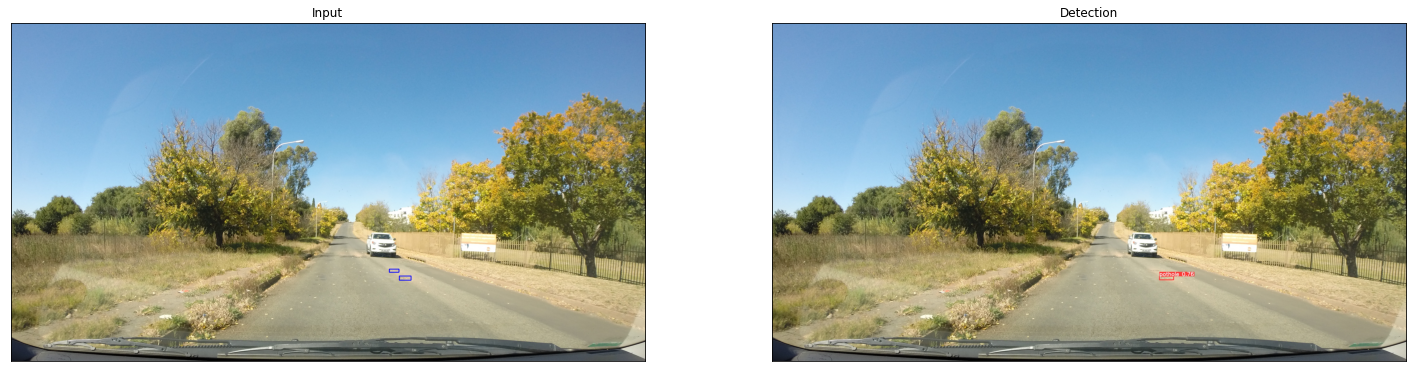

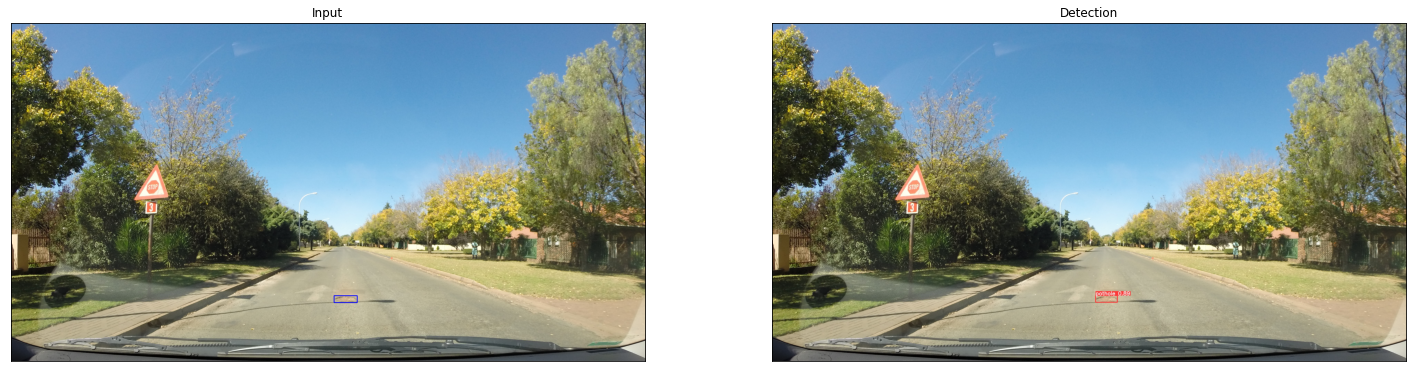

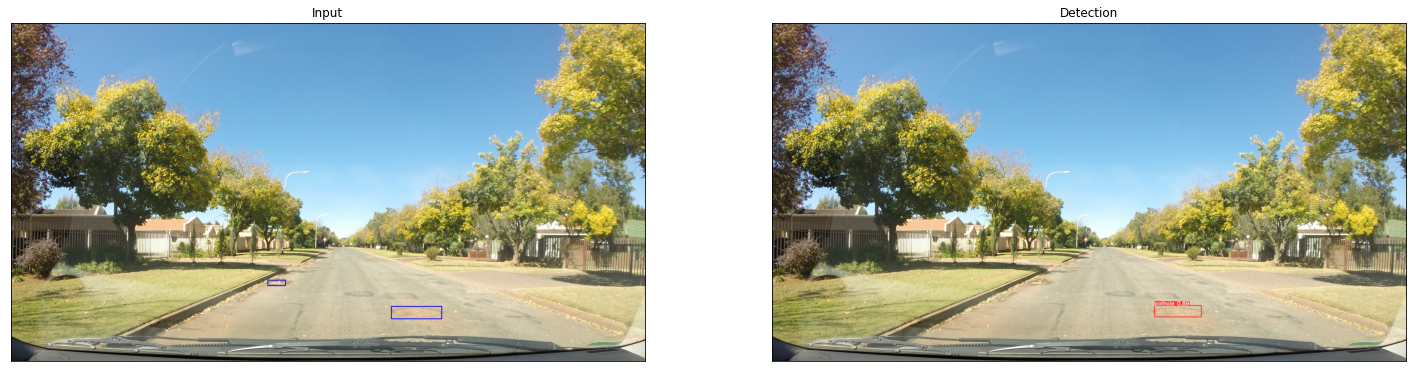

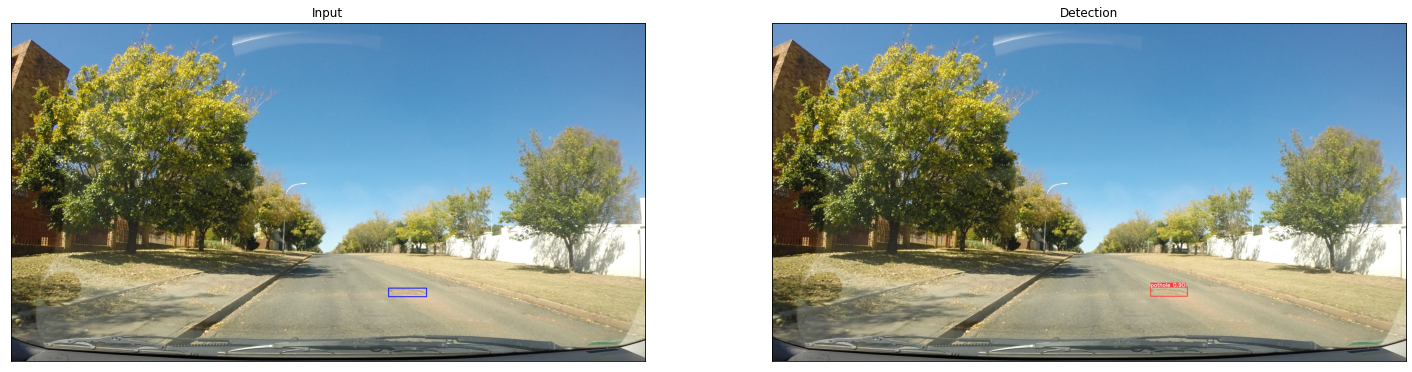

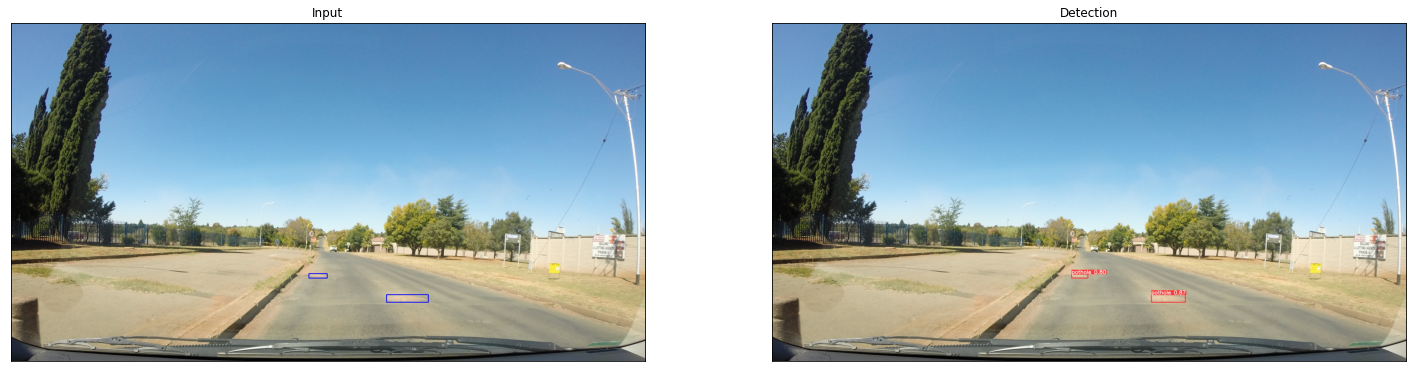

In [21]:
image_dir = 'processed_data/test_img'
result_dir = 'yolov5/runs/detect/exp9'

visualize_detection(image_dir, img_bbox_df, result_dir)

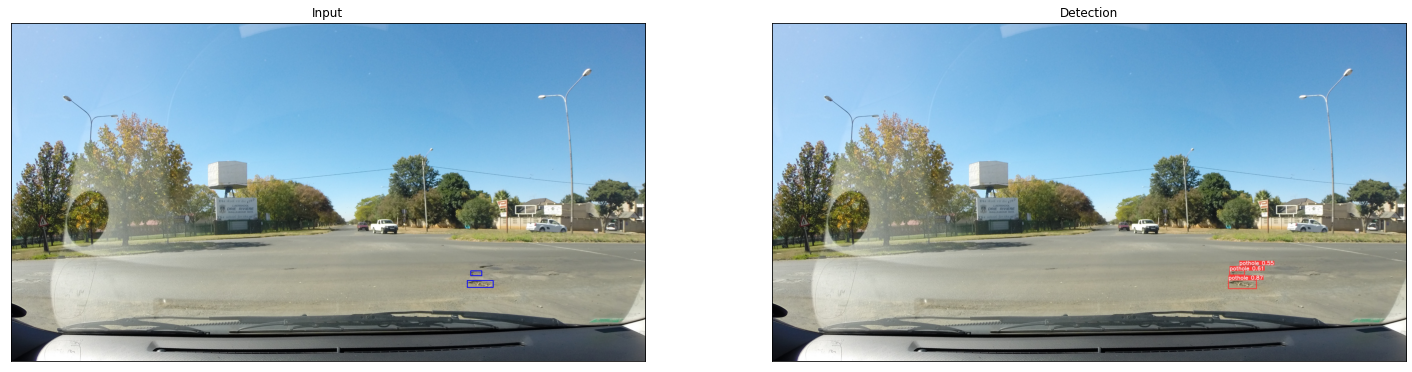

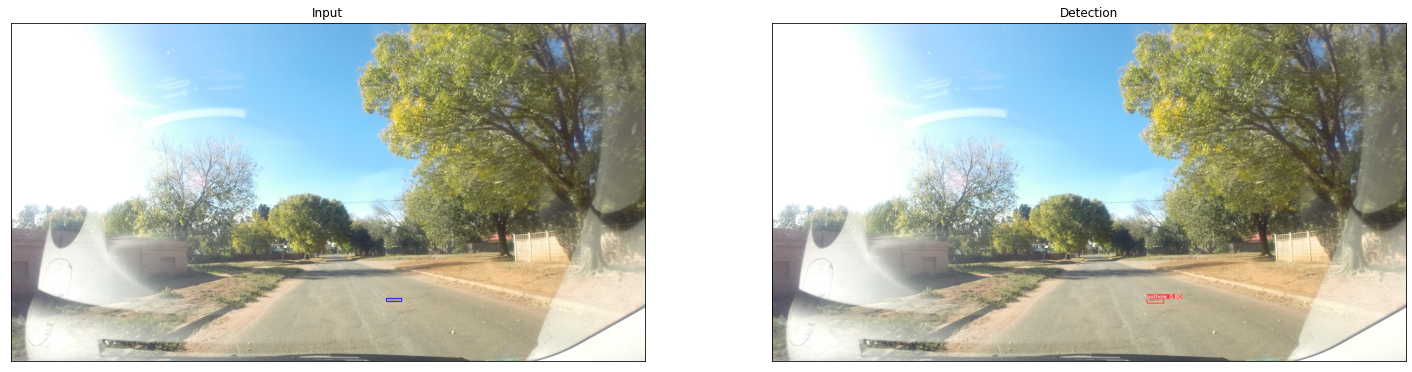

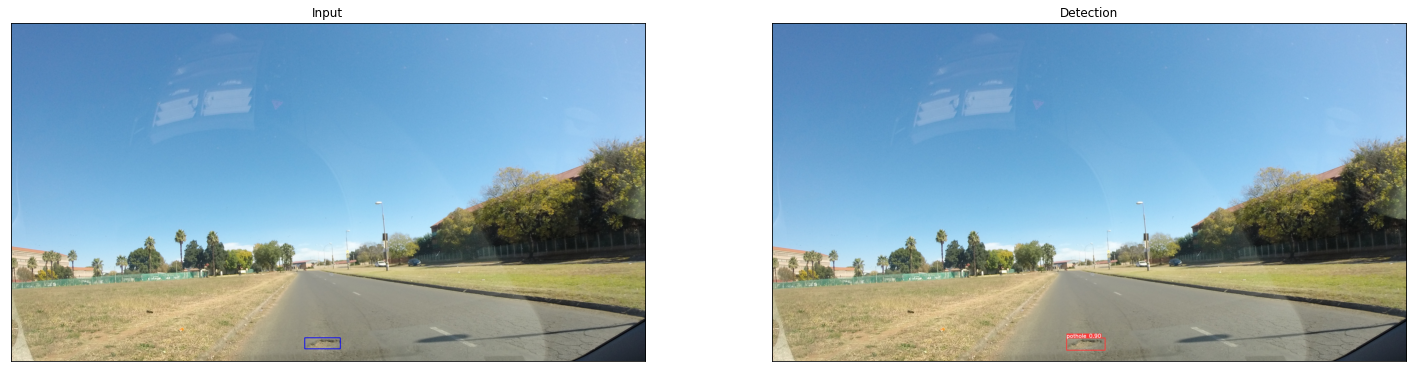

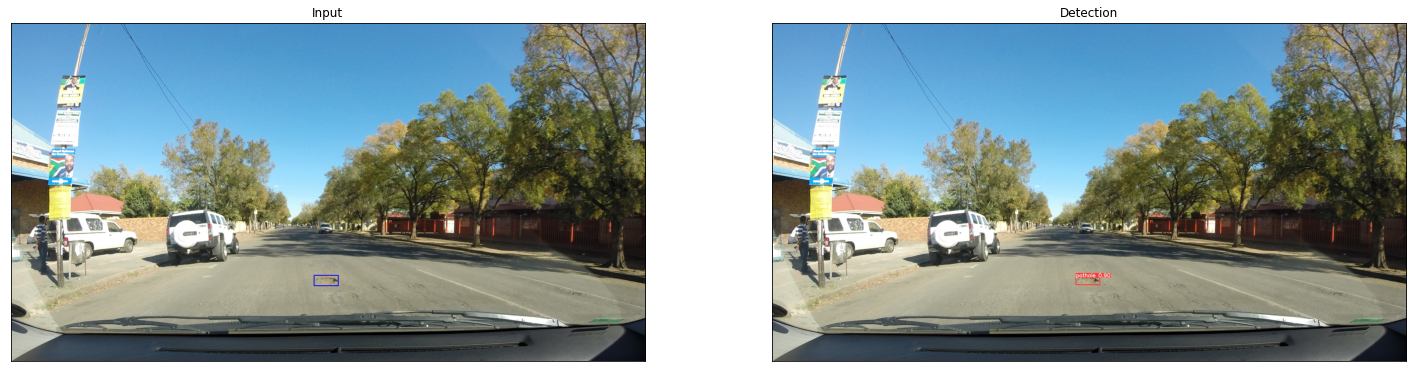

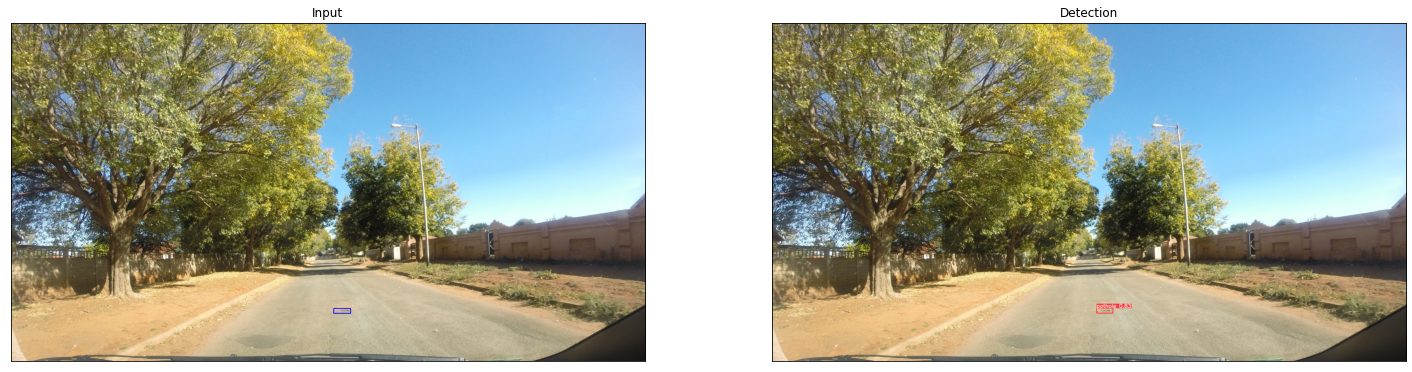

In [17]:
image_dir = 'processed_data/test'
result_dir = 'yolov5/runs/detect/exp9'

visualize_detection(image_dir, img_bbox_df, result_dir)